In [1]:
import sys
sys.path.append("../../XLEMOO")

In [2]:
from XLEMOO.LEMOO import EAParams, MLParams, LEMParams, LEMOO, PastGeneration
from XLEMOO.fitness_indicators import naive_sum, must_sum_to_one, asf_wrapper, single_objective, hypervolume_contribution, inside_ranges
from XLEMOO.tree_interpreter import instantiate_tree_rules, find_all_paths
from XLEMOO.problems import river_pollution_problem
from XLEMOO.plotting import plot_best_fitnesses, plot_mean_fitnesses, plot_std_fitnesses, plot_hypervolume, show_rules
from XLEMOO.selection import SelectNBest
from desdeo_emo.recombination import SBX_xover, BP_mutation
from desdeo_emo.selection import TournamentSelection
from desdeo_problem.testproblems import test_problem_builder
from desdeo_tools.scalarization.ASF import SimpleASF, GuessASF, StomASF, PointMethodASF
from desdeo_tools.utilities import hypervolume_indicator, epsilon_indicator_ndims, fast_non_dominated_sort_indices
from typing import List

from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
import matplotlib.pyplot as plt
import numpy as np
from imodels import C45TreeClassifier, SlipperClassifier, BoostedRulesClassifier, SkopeRulesClassifier
import imodels

## Define problem

In [3]:
n_objectives = 3
n_variables = 5

problem = test_problem_builder("DTLZ2", n_variables, n_objectives)
# problem = river_pollution_problem()

## Setting model parameters

In [104]:
nadir = np.ones(n_objectives)
ideal = np.zeros(n_objectives)
# ideal = np.array([-6.34, -3.44, -7.5, 0, 0])
# nadir = np.array([-4.75, -2.85, -0.32, 9.70, 0.35])
#ref_point = np.array([-5.0, -3.1, -4.4, 4.2, 0.15])
#guess_asf = asf_wrapper(GuessASF(nadir), {"reference_point": ref_point})

# fitness_fun = lambda x: guess_asf(x) + stom_asf(x) + np.random.uniform(0, 1)

# lower_limits = np.array([-5.5, -3.2, -5.4, 3.2, 0.05])
# upper_limits = np.array([-3.9, -2.9, -0.9, 7.2, 0.20])

lower_limits = np.array([0.4, 0.4, 0.6])
upper_limits = np.array([0.5, 0.5, 0.75])
ref_point = (lower_limits + upper_limits) / 2


stom_asf = asf_wrapper(StomASF(ideal=ideal), {"reference_point": ideal})
guess_asf = asf_wrapper(GuessASF(nadir), {"reference_point": ref_point})
ref_asf = asf_wrapper(PointMethodASF(ideal=ideal, nadir=nadir), {"reference_point": ref_point})
hyper_fun = hypervolume_contribution(nadir)
inside_ranges_fun = inside_ranges(lower_limits, upper_limits, sim_cost=0, asf_fun=ref_asf)


fitness_fun = lambda x: inside_ranges_fun(x)

# fitness_fun = naive_sum
# fitness_fun = hypervolume_contribution(nadir)

lem_params = LEMParams(
    use_darwin=True,
    use_ml=True,
    fitness_indicator=fitness_fun,
    ml_probe = 1,
    ml_threshold = 0.99999,
    darwin_probe = 5,
    darwin_threshold = 0.99999,
    total_iterations=10
)

ea_params = EAParams(
    population_size=20,
    cross_over_op=SBX_xover(),
    mutation_op=BP_mutation(problem.get_variable_lower_bounds(), problem.get_variable_upper_bounds()),
    # selection_op=TournamentSelection(None, tournament_size=3),
    selection_op=SelectNBest(None, 20),
    population_init_design="LHSDesign",
    iterations_per_cycle=1000,
)

# ml = DecisionTreeClassifier(random_state=0)
# ml = SlipperClassifier()
# ml = BoostedRulesClassifier()
ml = SkopeRulesClassifier(precision_min=0.5, n_estimators=20, max_features=None, max_depth=None, bootstrap=True, bootstrap_features=True, max_depth_duplication=10)
ml_params = MLParams(
    H_split=200,
    L_split=200,
    ml_model=ml,
    instantation_factor=10,
    generation_lookback=0,
    ancestral_recall=0,
    unique_only=True,
    iterations_per_cycle=1,
)

## Setup LEMOO model

In [105]:
lemoo = LEMOO(problem, lem_params, ea_params, ml_params)

In [106]:
lemoo.run_iterations()

h_gorup shape: (200, 5)
l_gorup shape: (200, 5)
.
h_gorup shape: (200, 5)
l_gorup shape: (200, 5)
.
h_gorup shape: (200, 5)
l_gorup shape: (200, 5)
.
h_gorup shape: (200, 5)
l_gorup shape: (200, 5)
.
h_gorup shape: (200, 5)
l_gorup shape: (200, 5)
.
h_gorup shape: (200, 5)
l_gorup shape: (200, 5)
.
h_gorup shape: (200, 5)
l_gorup shape: (200, 5)
.
h_gorup shape: (200, 5)
l_gorup shape: (200, 5)
.
h_gorup shape: (200, 5)
l_gorup shape: (200, 5)
.
h_gorup shape: (200, 5)
l_gorup shape: (200, 5)
.


{'darwin_mode': 10000, 'learning_mode': 10, 'total_iterations': 10}

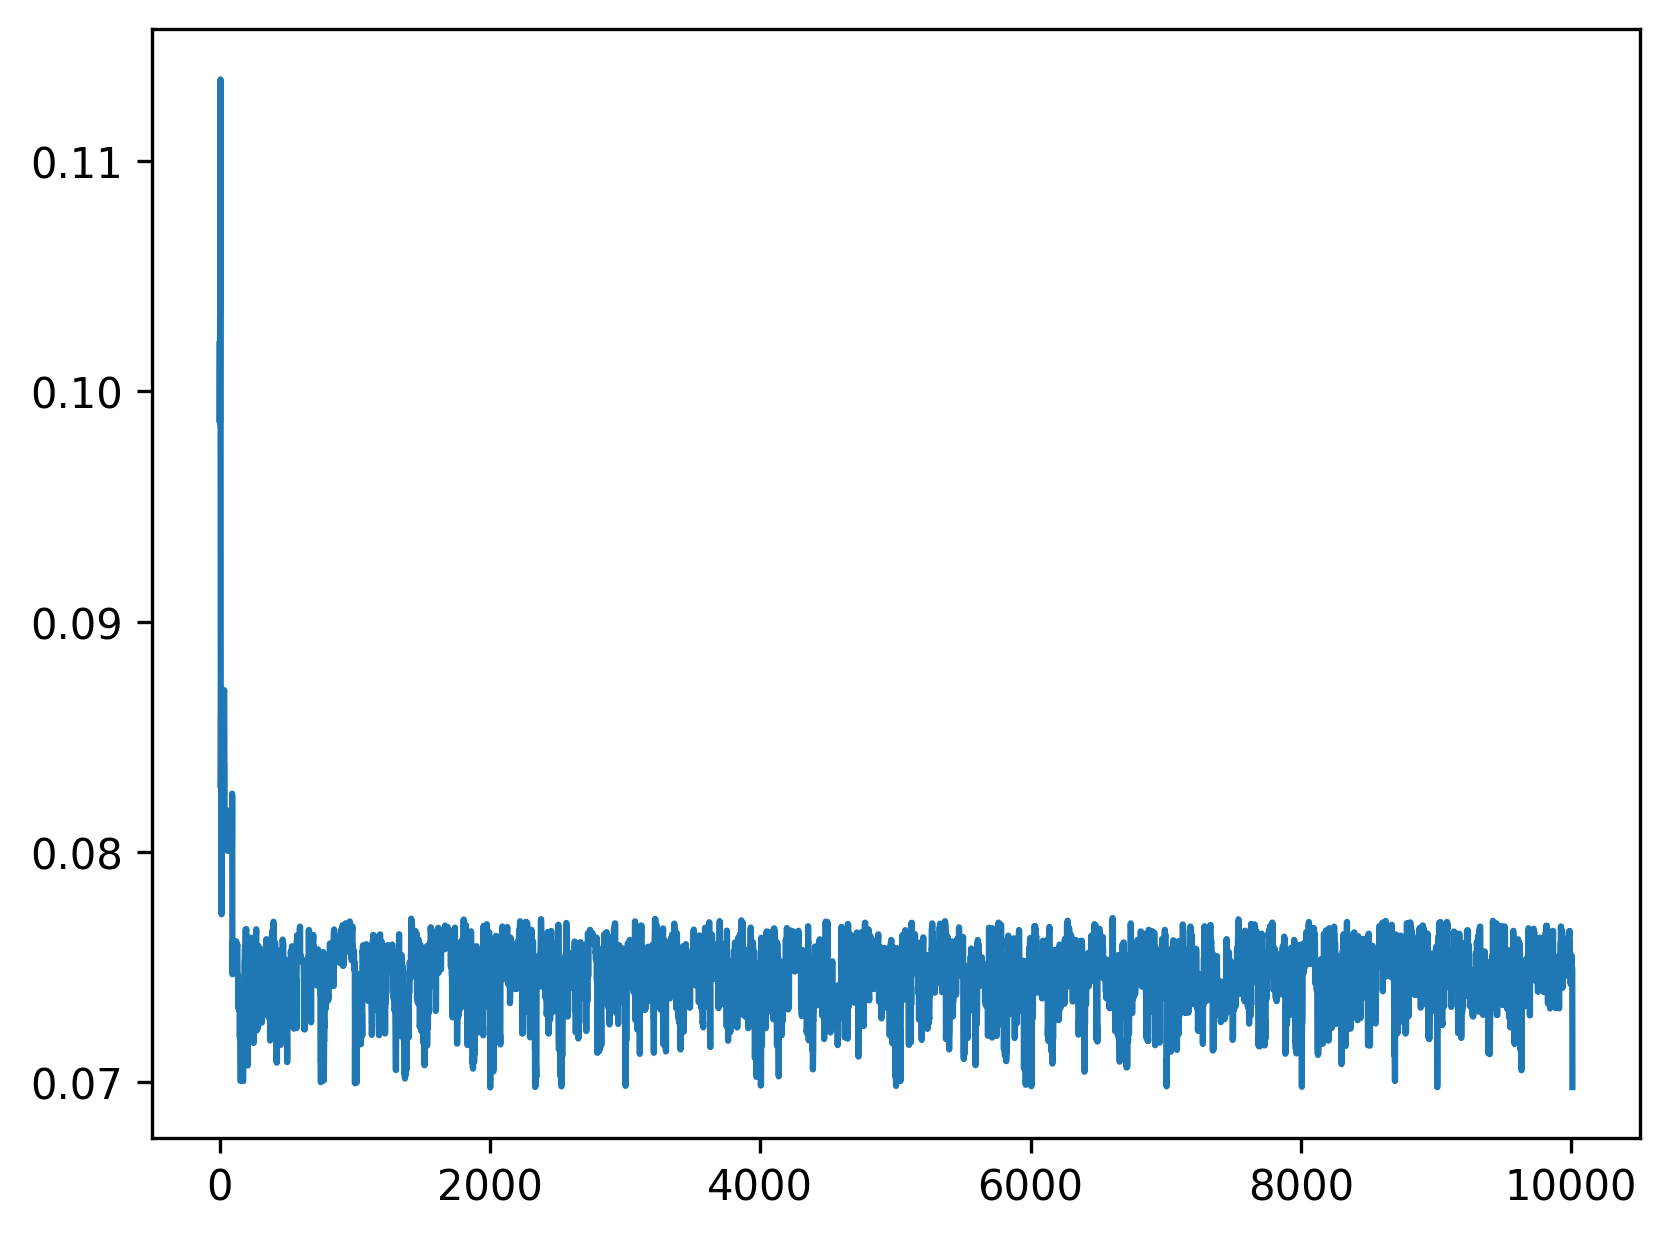

In [108]:
plot_hypervolume(lemoo._generation_history, ref_point=nadir)

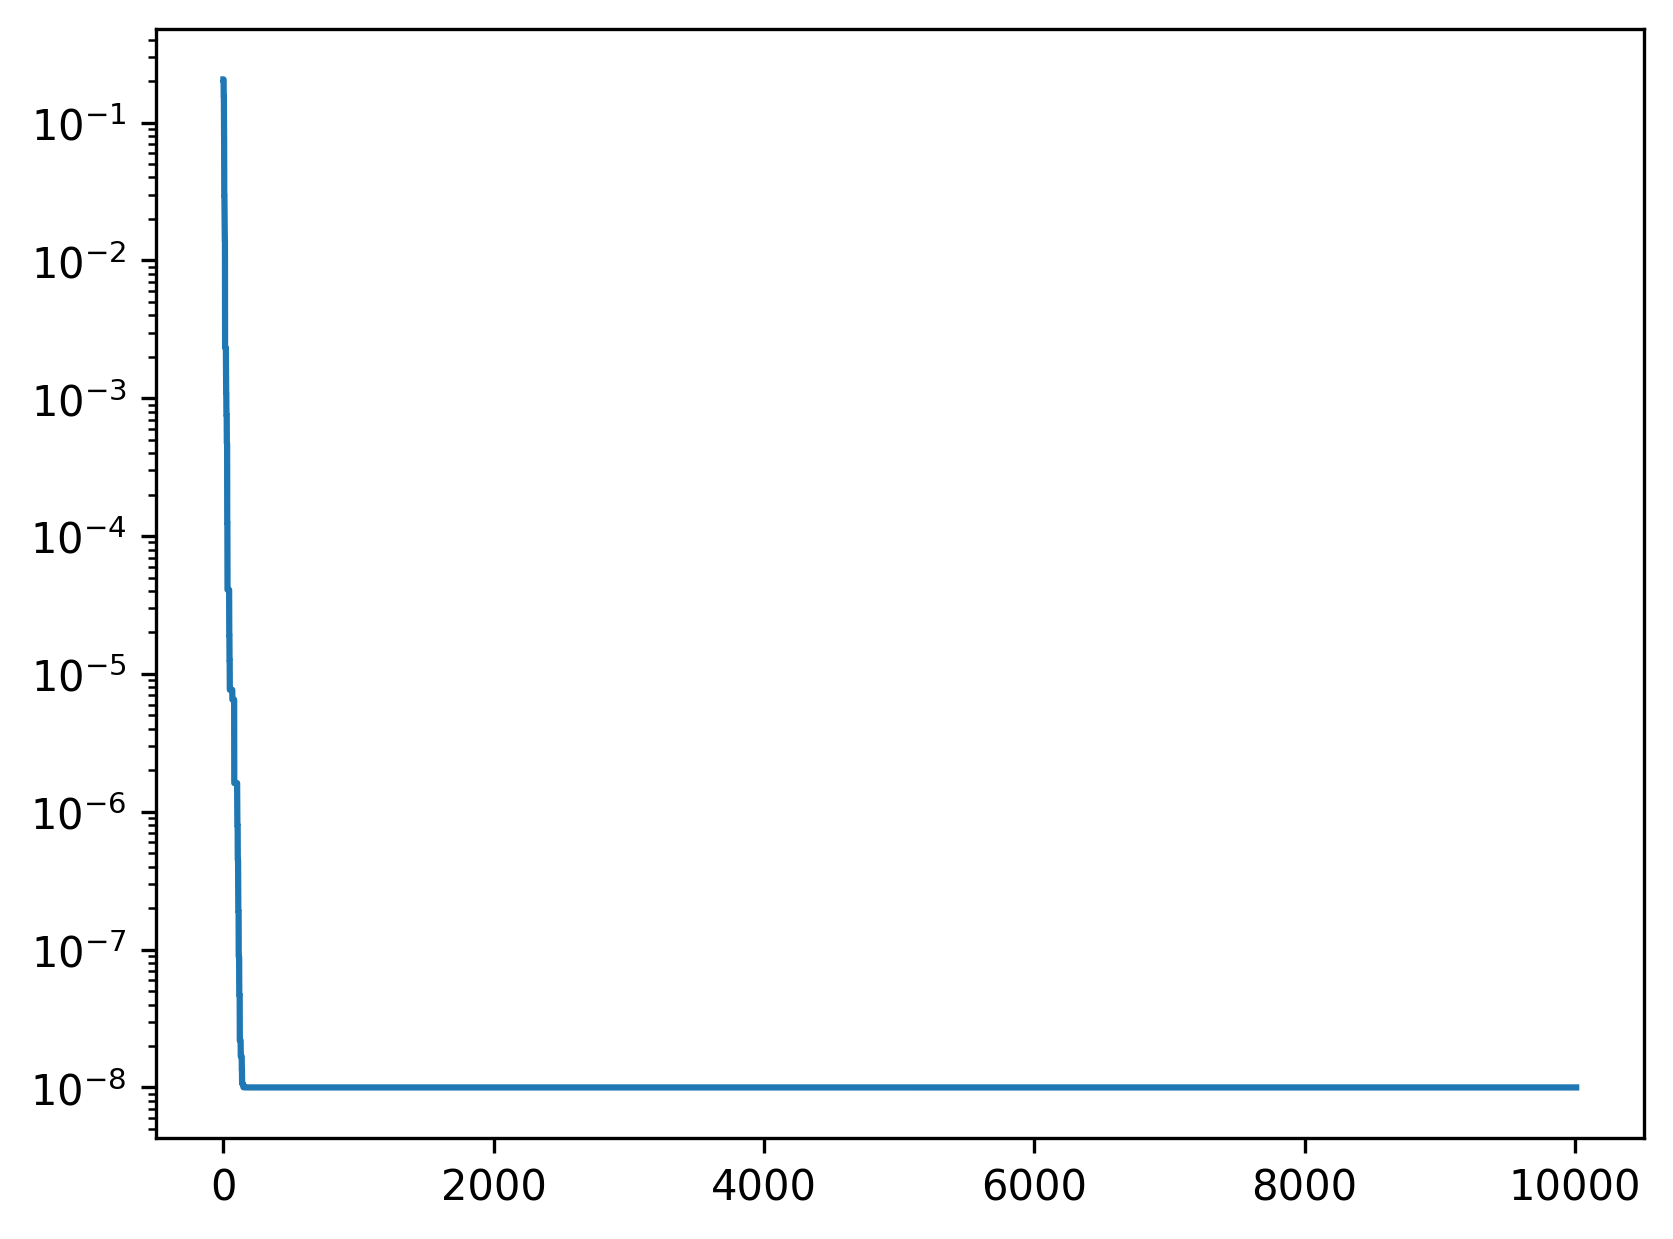

In [109]:
plot_best_fitnesses(lemoo._generation_history, ylog=True)

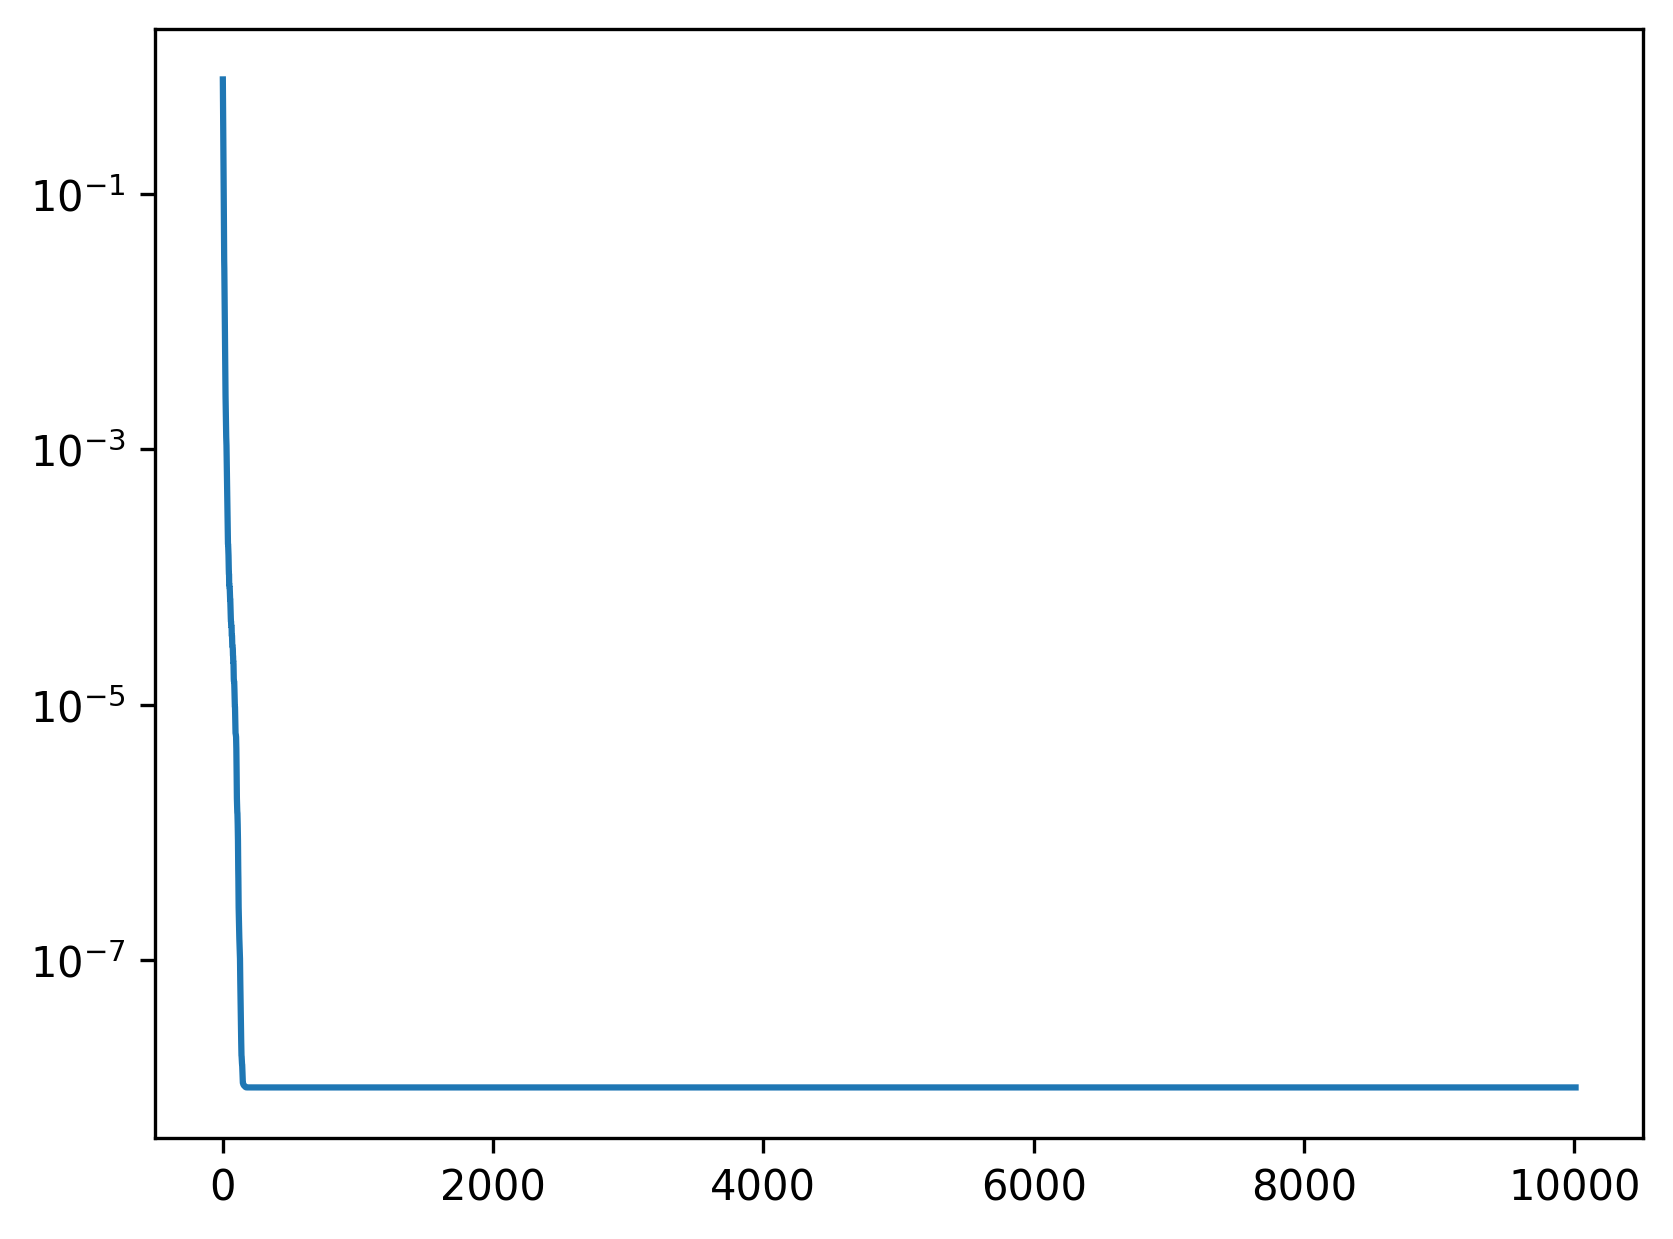

In [110]:
plot_mean_fitnesses(lemoo._generation_history, ylog=True)

SkopeRulesClassifier(bootstrap=True, bootstrap_features=True, max_depth=None,
                     max_depth_duplication=10, max_features=None,
                     n_estimators=20)


AttributeError: 'SkopeRulesClassifier' object has no attribute 'tree_'

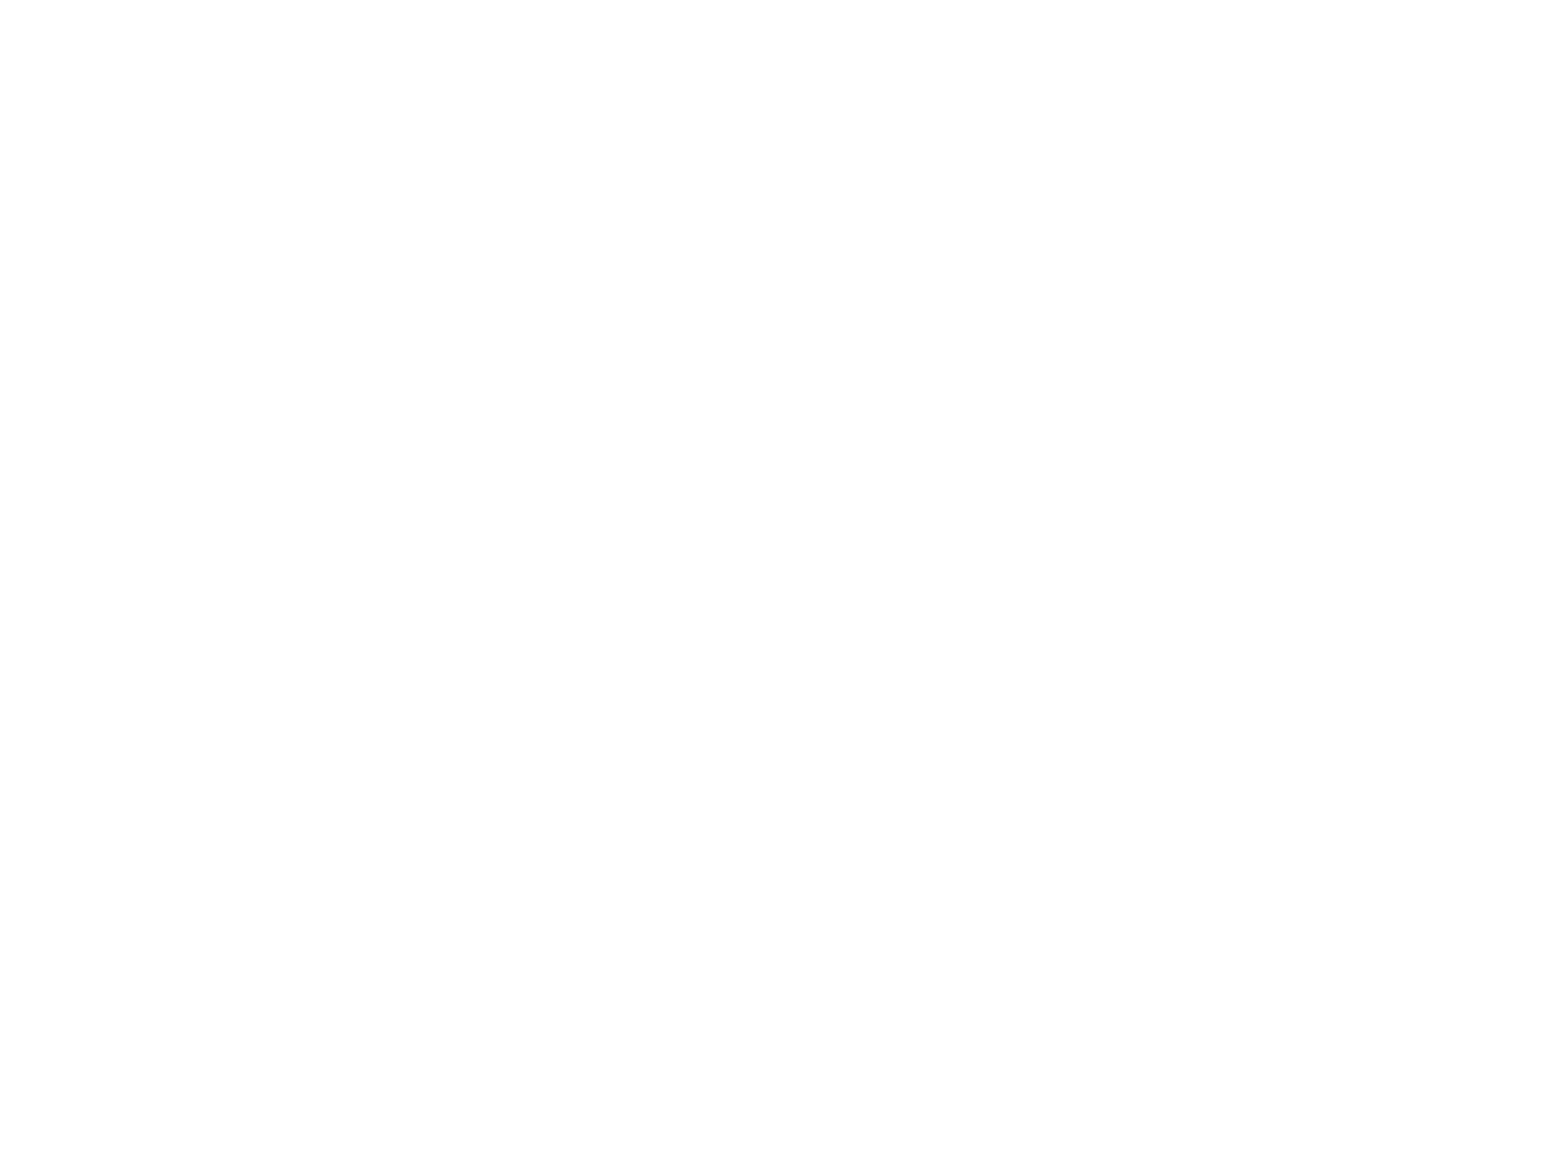

In [111]:
print(lemoo.current_ml_model)
tree.plot_tree(lemoo.current_ml_model)

In [112]:
print(problem.evaluate(lemoo._generation_history[-1].individuals[0]).objectives)
print(lower_limits)
print(upper_limits)

[[0.46166712 0.48256651 0.75000001]]
[0.4 0.4 0.6]
[0.5  0.5  0.75]


In [113]:
np.min(lemoo._generation_history[-1].fitness_fun_values)


1.0010312578856428e-08

In [114]:
# print(lemoo.current_ml_model.rules_[1])
show_rules(lemoo.current_ml_model.rules_)

Rule -> Accuracy:
X_3 <= 0.50748 and X_3 > 0.5033 --> 1.0
X_0 <= 0.54087 and X_1 <= 0.52101 and X_1 > 0.51377 --> 1.0
X_0 <= 0.53805 and X_0 > 0.53682 --> 1.0
X_1 <= 0.52009 and X_1 > 0.51377 and X_4 <= 0.54179 --> 1.0
X_1 <= 0.52009 and X_1 > 0.51184 --> 0.9565217391304348


In [115]:
#print(np.logical_and(lemoo._generation_history[-1].objectives_fitnesses <= upper_limits, lemoo._generation_history[-1].objectives_fitnesses >= lower_limits))
a = lemoo._generation_history[-1].objectives_fitnesses[0:3]

fitness_fun(np.atleast_2d(a))

array([[1.00103126e-08],
       [1.00103126e-08],
       [1.00103126e-08]])

In [116]:
lemoo._generation_history[-2].individuals

array([[0.53685036, 0.51423694, 0.55462416, 0.5074043 , 0.53472549],
       [0.53685036, 0.51232643, 0.55462416, 0.5074043 , 0.53472549],
       [0.53685036, 0.47024405, 0.55462416, 0.5074043 , 0.53472549],
       [0.53685036, 0.49015338, 0.55462416, 0.5074043 , 0.53472549],
       [0.53685036, 0.48113638, 0.55462416, 0.5074043 , 0.53472549],
       [0.53685036, 0.48919349, 0.55462416, 0.5074043 , 0.53472549],
       [0.53685036, 0.48106867, 0.55462416, 0.5074043 , 0.53472549],
       [0.53685036, 0.51237322, 0.55462416, 0.5074043 , 0.53472549],
       [0.53685036, 0.50497716, 0.55462416, 0.5074043 , 0.53472549],
       [0.53685036, 0.51363786, 0.55462416, 0.5074043 , 0.53472549],
       [0.53685036, 0.48864586, 0.55462416, 0.5074043 , 0.53472549],
       [0.53685036, 0.52409535, 0.55462416, 0.5074043 , 0.53472549],
       [0.53685036, 0.51336788, 0.55462416, 0.5074043 , 0.53472549],
       [0.53685036, 0.48257105, 0.55462416, 0.5074043 , 0.53472549],
       [0.53685036, 0.5141654 , 0.

In [117]:
upper_limits

array([0.5 , 0.5 , 0.75])

In [ ]:
a - lower_limits

In [ ]:
upper_limits - a

In [ ]:
lower = np.where(a - lower_limits > 0, 0, np.abs(a - lower_limits))
upper = np.where(upper_limits - a > 0, 0, np.abs(upper_limits - a))

In [ ]:
lower

In [ ]:
upper

In [ ]:
lower + upper

In [ ]:
np.sum(lower + upper, axis=1).T

In [ ]:
fitness_fun(a)